# Уравнение Пуассона и уравнение теплопроводности. Метод простых итераций.

In [ ]:
import numpy as np
import matplotlib as ml
import matplotlib.pyplot as pp

In [ ]:
%matplotlib inline

* http://ipython.org/ipython-doc/stable/notebook/notebook.html#plotting

##1 Решаем уравнение Пуассона

Мы хотим решить уравнение Пуассона,

$$\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} = 0$$

в $[0,1] \times [0,1]$ квадратная область с граничными условиями

$$u(x,0) = x, \quad u(x,1) = x - 1, \quad u(0,y) = -y, \quad u(1,y) = 1 - y.$$

Мы будем использовать конечно-разностное представление низшего порядка

$$\frac{\partial^2 u}{\partial x^2}(x_i,y_j)
\simeq \frac{1}{\Delta x} \left( \frac{\partial u}{\partial x}(x_{i+1},y_j) - \frac{\partial u}{\partial x}(x_{i-1},y_j) \right) \\
\simeq \frac{1}{\Delta x} \left( \frac{1}{\Delta x} \left( u(x_{i+1},y_j) - u(x_i,y_j) \right)
- \frac{1}{\Delta x} \left( u(x_{i},y_j) - u(x_{i-1},y_j) \right) \right)$$

Отсюда получаем

$$\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \simeq \left( \frac{1}{\Delta^2}(u_{i+1,j} + u_{i-1,j} + u_{i,j+1} + u_{i,j-1} - 4u_{i,j}) \right)$$

Метод простых итераций Якоби, он же процесс усреднения Либмана, или метод средних арифметических 

$$
u_{i, j}^{(n+1)}=\frac{1}{4}\left(u_{i+1, j}^{(n)}+u_{i-1, j}^{(n)}+u_{i, j+1}^{(n)}+u_{i, j-1}^{(n)}-h^2 f\left(x_i^{(n)}, y_j^{(n)}\right) \mid, n=0,1,2, \ldots\right. 
$$

Для получения начальных приближений можно указать два способа:

1. значения во внутренних узлах получают путем интерполирования, использующего известные граничные условия;

2. составляют систему конечно-разностных уравнений для сетки с более крупным шагом и решают ее методом исключения, а затем полученные значения интерполируют на узлы данной сетки.

Для любого шага $h$ процесс Либмана сходится к точному решению независимо от выбора начальных значений, потому что выполнено условие диагонального преобладания матрицы СЛАУ.  

###1.1 Прямое решение.

Самый прямой подход состоит в том, чтобы решить линейную систему напрямую:

In [ ]:
def boundary(grid):
    x = np.linspace(0,1,len(grid))
    
    grid[0,:]  = np.interp(x,[0,1],[0,1])
    grid[:,-1] = np.interp(x,[0,1],[1,0])
    grid[-1,:] = np.interp(x,[0,1],[-1,0])
    grid[:,0]  = np.interp(x,[0,1],[0,-1])

In [ ]:
def poisson_direct(gridsize,set_boundary):
    A = np.zeros(shape=(gridsize,gridsize,gridsize,gridsize),dtype='d')
    b = np.zeros(shape=(gridsize,gridsize),dtype='d')
    
    dx = 1.0 / (gridsize - 1)
    
    # discretized differential operator
    for i in range(1,gridsize-1):
        for j in range(1,gridsize-1):
            A[i,j,i-1,j] = A[i,j,i+1,j] = A[i,j,i,j-1] = A[i,j,i,j+1] = 1/dx**2
            A[i,j,i,j] = -4/dx**2
    
    # boundary conditions
    for i in range(0,gridsize):
        A[0,i,0,i] = A[-1,i,-1,i] = A[i,0,i,0] = A[i,-1,i,-1] = 1
    
    # set the boundary values on the right side
    set_boundary(b)
    
    return np.linalg.tensorsolve(A,b)

In [ ]:
sol = poisson_direct(25,boundary)

Чтобы показать решение, нам нужно соединить обычную интерпретацию матрицы (строка, столбец, сверху и слева) с идеей построения на декартовой плоскости.

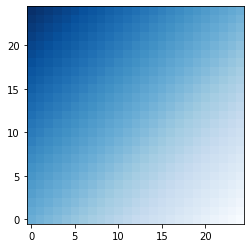

In [ ]:
pp.imshow(sol.T,cmap=ml.cm.Blues,interpolation='none',origin='lower')

Превратите это в функцию, которую мы будем использовать снова.

In [ ]:
def showsol(sol):
    pp.imshow(sol.T,cmap=ml.cm.Blues,interpolation='none',origin='lower')

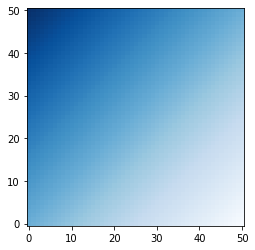

In [ ]:
showsol(poisson_direct(51,boundary))

Насколько быстро работает?

In [ ]:
%timeit poisson_direct(65,boundary)

1.68 s ± 315 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### 1.2 Решение итерациями.

Попробуем итерационный метод: решим уравнение Пуассона, превратив его в уравнение диффузии 

$$\frac{\partial u}{\partial t} = \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}$$

и решим его  с помощью прямого пространственно-временного дифференцирования (FTCS)

$$u^{n+1}_{i,j} = u^{n}_{i,j} + \frac{\Delta t}{\Delta^2}(u^{n}_{i+1,j} + u^{n}_{i-1,j} + u^{n}_{i,j+1} + u^{n}_{i,j-1} - 4u^n_{i,j})$$

с наибольшим стабильным устойчивым шагом по времени $\Delta t = \Delta^2/4$ [1]

$$u^{n+1}_{i,j} = \frac{1}{4}(u^{n}_{i+1,j} + u^{n}_{i-1,j} + u^{n}_{i,j+1} + u^{n}_{i,j-1}),$$

что сводится к замене каждого значения сетки средним значением его ближайших соседей.

[1] Анализ устойчивости по фон Нейману_ схемы FTCS основан на решении эволюции _коэффициента усиления_ $\xi(k)$ для режимов вида $u^n_j = \xi^n e^{i k j \Delta x}$ .

In [ ]:
def jacobi(grid):
    newgrid = np.zeros(shape=grid.shape,dtype=grid.dtype)

    # apply evolution operator
    newgrid[1:-1,1:-1] = 0.25 * (grid[1:-1,:-2] + grid[1:-1,2:] +
                                 grid[:-2,1:-1] + grid[2:,1:-1])

    # copy boundary conditions
    newgrid[0,:]  = grid[0,:]
    newgrid[-1,:] = grid[-1,:]
    newgrid[:,0]  = grid[:,0]
    newgrid[:,-1] = grid[:,-1]
    
    return newgrid

Мы начинаем со случайной конфигурации, применяем граничные условия и повторяем.

In [ ]:
def initgrid(gridsize):
    x = np.random.randn(gridsize,gridsize)
    boundary(x)
    
    return x

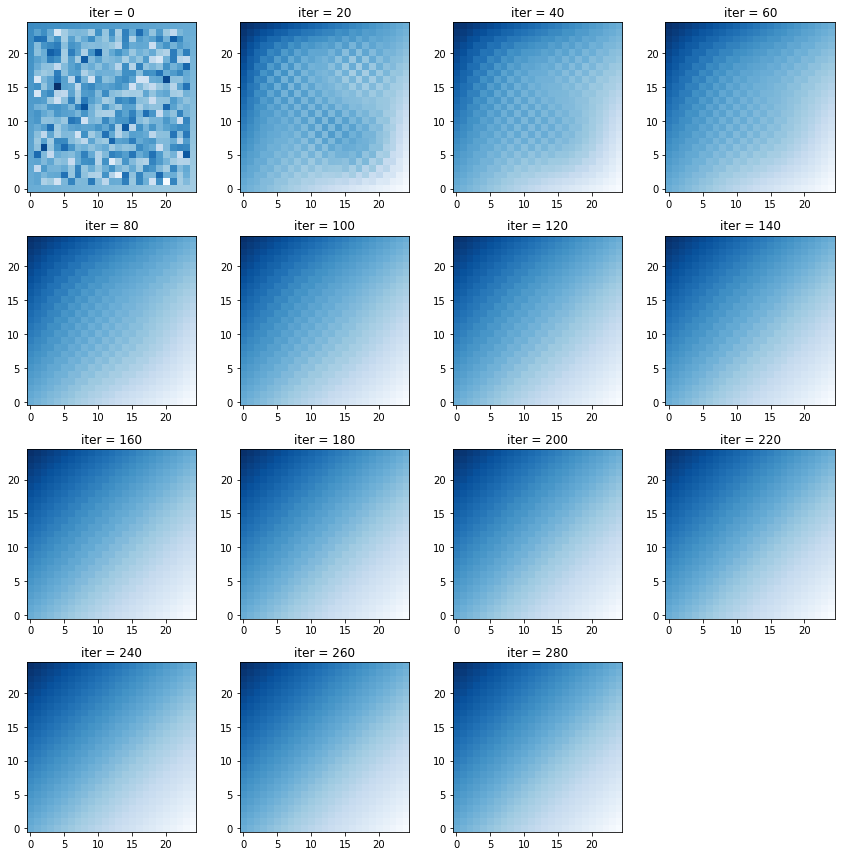

In [ ]:
x = initgrid(25)

pp.figure(figsize=(12,12))

for i in range(300):    
    if i % 20 == 0:
        pp.subplot(4,4,i//20+1)
        showsol(x)
        pp.title('iter = %s' % i)
        
    x = jacobi(x)

pp.tight_layout()

На самом деле интереснее наблюдать за эволюцией ошибки, которую мы определяем как норму повторного решения минус точное (прямое) решение. 

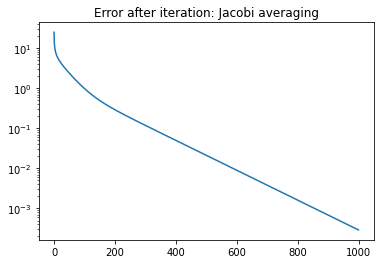

In [ ]:
x = initgrid(25)
sol = poisson_direct(25,boundary)

err_jacobi = []

for i in range(1000):    
    err_jacobi.append((i,np.linalg.norm(x - sol)))
            
    x = jacobi(x)

err_jacobi = np.array(err_jacobi)
    
pp.semilogy(err_jacobi[:,0],err_jacobi[:,1])
pp.title('Error after iteration: Jacobi averaging');

In [ ]:
%%timeit

x = initgrid(65)

for i in range(1000):    
    x = jacobi(x)

27.9 ms ± 719 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Давайте рассмотрим решение с помощью классического метода Гаусса-Зейделя

In [ ]:
def gauss_seidel(grid):
    newgrid = grid.copy()
    
    for i in range(1,newgrid.shape[0]-1):
        for j in range(1,newgrid.shape[1]-1):
            newgrid[i,j] = 0.25 * (newgrid[i,j+1] + newgrid[i,j-1] +
                                   newgrid[i+1,j] + newgrid[i-1,j])
    
    return newgrid

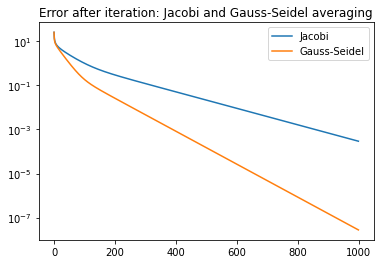

In [ ]:
x = initgrid(25)
sol = poisson_direct(25,boundary)

err_gs = []

for i in range(1000):    
    err_gs.append((i,np.linalg.norm(x - sol)))
            
    x = gauss_seidel(x)

err_gs = np.array(err_gs)
    
pp.semilogy(err_jacobi[:,0],err_jacobi[:,1])
pp.semilogy(err_gs[:,0],err_gs[:,1])

pp.title('Error after iteration: Jacobi and Gauss-Seidel averaging')
pp.legend(['Jacobi','Gauss-Seidel']);

Скорость сходимости задается наибольшим собственным значением матрицы итерации, известной как спектральный радиус. Это $1-\pi^2/(2J^2)$ для Якоби, $1 - \pi^2/J^2$ для Гаусса–Зейделя.

Для Якоби количество итераций для уменьшения ошибки в $10^{-p}$ раз равно $\simeq p J^2/2$, а для Гаусса–Зейделя — $p J^2/4$.


Циклы Python значительно замедляют работу Гаусса-Зейделя...

In [ ]:
%%timeit

x = initgrid(65)

for i in range(1000):    
    x = gauss_seidel(x)

4.35 s ± 226 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Мы можем значительно ускорить его, используя **Cython** (по сути, Python, скомпилированный в C, с объявленными типами для эффективности).

* http://cython.org
* IPython `cythonmagic` расширение, которое автоматически компилирует код Cython и загружает функции в текущую сессию Python: http://ipython.org/ipython-doc/stable/config/extensions/cythonmagic.html

https://colab.research.google.com/drive/1oXcSCor9mH72N8NVeYX4Sl2jD0UWII2n#scrollTo=-WnbuIkZMpU-    Getting started with Cython 

In [ ]:
%load_ext cython

In [ ]:
%%cython

import numpy
cimport numpy

def gauss_seidel_fast(grid):
    cdef numpy.ndarray[numpy.double_t,ndim=2] newgrid = grid.copy()
    cdef int i,j
    
    for i in range(1,newgrid.shape[0]-1):
        for j in range(1,newgrid.shape[1]-1):
            newgrid[i,j] = 0.25 * (newgrid[i,j+1] + newgrid[i,j-1] +
                                   newgrid[i+1,j] + newgrid[i-1,j])
    
    return newgrid

In [ ]:
%%timeit

x = initgrid(65)

for i in range(1000):    
    x = gauss_seidel_fast(x)

30.5 ms ± 883 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## 2. Решаем уравнение теплопроводности.

$$
u_t=u_{x x}+u_{y y}+f(x, y)  
$$

Начальное условие

$$
u(t=0, x, y)=u_0(x, y)=0 
$$

И добавляются граничные условия.

Простейший алгоритм заключается в следующем: 

-  считаем производную по времени во всех точках, вычислив правую часть уравнения с помощью численного дифференцирования

-  вычисляем первое приближение $u(x,y)$ в следующий момент времени, добавив производную по времени, умноженную на шаг по времени

-  вычисляем снова  производную по времени 

-  используем эту производную по времени, чтобы поставить и решить краевую задачу, получив второе приближение $u(x,y)$ 

- повторяем шаг алгоритма


Впрочем, в методе простых итераций постпуают ещё проще, не вводя двух разных приближений $u(x,y)$  в один и тот же момент времени: 

-  считаем производную по времени во всех точках, вычислив правую часть уравнения с помощью численного дифференцирования

-  вычисляем  $u(x,y)$ в следующий момент времени, добавив производную по времени, умноженную на шаг по времени

- повторяем шаг алгоритма

Оба метода работают довольно медленно. Более быстрый способ мы изучим на следующем семинаре. 



## 3.  Задания для самостоятельного решения. 

### 1. Уравнение Пуассона.

Требуется решить двумерное уравнение Пуассона: $u_{x x}+u_{y y}=f(x, y)$, на многосвязной области интегрирования с нулевым начальным приближением и различными граничными условиями первого или второго типа.  

Граничные условия берем из папки D3, документ  Laba_task.

Можно решить как на Питоне, так и с помощью программы в папке. 


### 2. Уравнение теплопроводности.

Требуется решить двумерное уравнение параболического типа: $u_t=u_{x x}+u_{y y}+f(x, y)$, на многосвязной области интегрирования с нулевым начальным условием $u(t=0, x, y)=u_0(x, y)=0$ и различными граничными условиями первого или второго типа. 

Граничные условия берем из папки D4, документ Laba_task.

Можно решить как на Питоне, так и с помощью программы в папке.

**Указание.**

Граничное условие на производную вдоль нормали можно следующим образом задать:

\begin{gathered}
\frac{\partial \varphi}{\partial \vec{n}}=0 \\
\frac{\partial \varphi}{\partial \vec{n}}=(\operatorname{grad\varphi }, \vec{n}) \\
\vec{n}=\frac{\left(x-x_0, y-y_0\right)}{\sqrt{\left(x-x_0\right)^2+\left(y-y_0\right)^2}} \\
\operatorname{grad\varphi }=\left(\frac{\partial \varphi}{\partial x}, \frac{\partial \varphi}{\partial y}\right) \\
\frac{\partial \varphi}{\partial x} \simeq\left(\varphi_{i+1, j}-\varphi_{i, j}\right) \frac{1}{\Delta x} \\
\frac{\partial \varphi}{\partial y} \approx\left(\varphi_{i, j+1}-\varphi_{i, j}\right) \cdot \frac{1}{\Delta y}
\end{gathered} 

Отсюда применительно к нашей задаче на границе круга будем писать:

\begin{aligned}
& \left(u_{i, j}-u_{i+1, j}\right) / h * n_x+\left(u_{i, j}-u_{i, j+1}\right) / h * n_y=0 \\
& u_{i, j}=u_{i+1, j} \cdot n_x+u_{i, j+1} \cdot n_y
\end{aligned}

Граничными точками будем называть такие, для которых внутри круга нет хотя бы одной из 4 соседних. Например, для точки (i, j) соседними будем называть точки  (i+1, j), (i, j+1), (i-1, j), (i, j-1). 